# DD Neutron Post Capture Propagation

Analysis of DD simulation of 10,000 neutrons where optics was turned on.
Purpose is to look at neutrons on 

In [49]:
import gdls_physics
import time
import glob
import matplotlib.pyplot as plt
import numpy as np
import tabulate

## Load Neutrons

In [48]:
file_names = glob.glob('/hdfs/user/ak18773/od_likelihood/pure_dd/baccarat_verbose/*.npy')
neutron_dictionaries = gdls_physics.baccarat_verbose_reader.extract_particle_from_dict(file_names, particle='neutron', merge_multiples=True)

Number to process = 4500 
Progress: [####################] 100.0% 
Average time 0.7s 
Time: 00:50:06 
Remaining time 00:00:00


In [51]:
np.save('/scratch/ak18773/dd_neutrons.npy',neutron_dictionaries)

In [52]:
end_loc = [neutron['NextVolume'][-1] for neutron in neutron_dictionaries]
unique_volumes = np.unique(end_loc)
end_volume_weights = []
vols = []
for uni in unique_volumes:
    count = 0
    for j in end_loc:
        if j == uni:
            count += 1
    if count > 10:
        end_volume_weights.append(count)
        vols.append(uni)

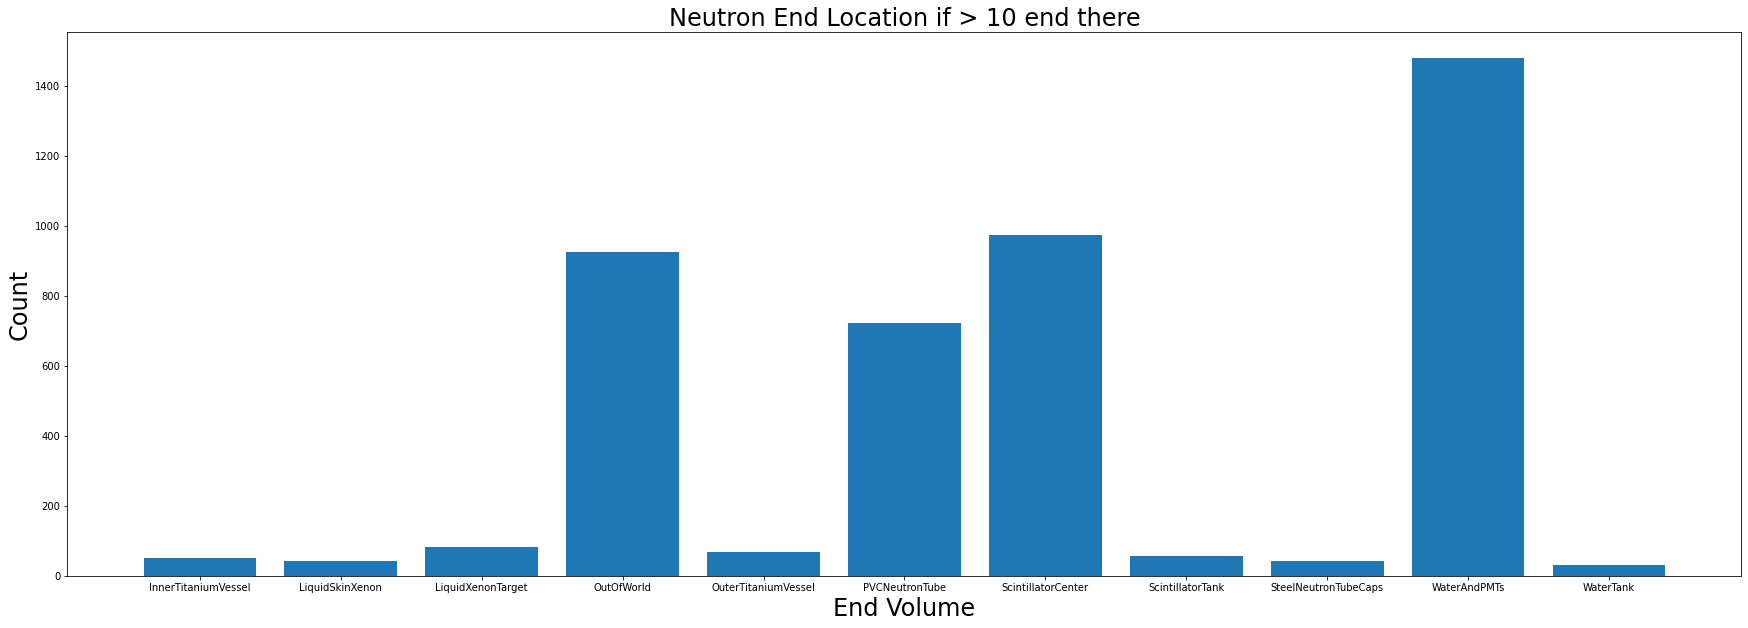

In [53]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
ax.set_ylabel('Count', size = 24 )
ax.set_xlabel('End Volume', size = 24 )
ax.set_title('Neutron End Location if > 10 end there', size = 24 ) 
ax.bar(vols, end_volume_weights)
plt.show()

In [54]:
unique_volumes = np.unique(end_loc)
non_ofw = [vols for vols in end_loc if vols != 'OutOfWorld']
end_volume_weights = []
vols = []
others = 0
for uni in unique_volumes:
    count = 0
    for j in end_loc:
        if j == uni:
            count += 1
    if count > 10:
        if uni != 'OutOfWorld':
            end_volume_weights.append([uni, count/len(end_loc) * 100, count/len(non_ofw) * 100])
        else:
            end_volume_weights.append([uni, count/len(end_loc) * 100, '-'])
    else:
        others += count
end_volume_weights.append(['other', others/len(end_loc) * 100, others/len(non_ofw) * 100])
end_volume_weights.sort(key = lambda i: i[1],reverse = True)

In [55]:
print(tabulate.tabulate(end_volume_weights, headers=['Detector Volume', 'Percentage (%)', 'Percentage (%)']))

Detector Volume         Percentage (%)  Percentage (%)
--------------------  ----------------  ------------------
WaterAndPMTs                 32.8889    41.3986013986014
ScintillatorCenter           21.6667    27.27272727272727
OutOfWorld                   20.5556    -
PVCNeutronTube               16.0889    20.251748251748253
LiquidXenonTarget             1.84444   2.3216783216783217
OuterTitaniumVessel           1.51111   1.902097902097902
ScintillatorTank              1.28889   1.6223776223776225
InnerTitaniumVessel           1.11111   1.3986013986013985
SteelNeutronTubeCaps          0.955556  1.202797202797203
LiquidSkinXenon               0.911111  1.1468531468531469
WaterTank                     0.711111  0.8951048951048951
other                         0.466667  0.5874125874125874


### End Process

In [56]:
end_process = [neutron['ProcName'][-1] for neutron in neutron_dictionaries]
unique_processes = np.unique(end_process)
end_process_weights = []
procs = []
for uni in unique_processes:
    count = 0
    for j in end_process:
        if j == uni:
            count += 1
    end_process_weights.append(count)
    procs.append(uni)

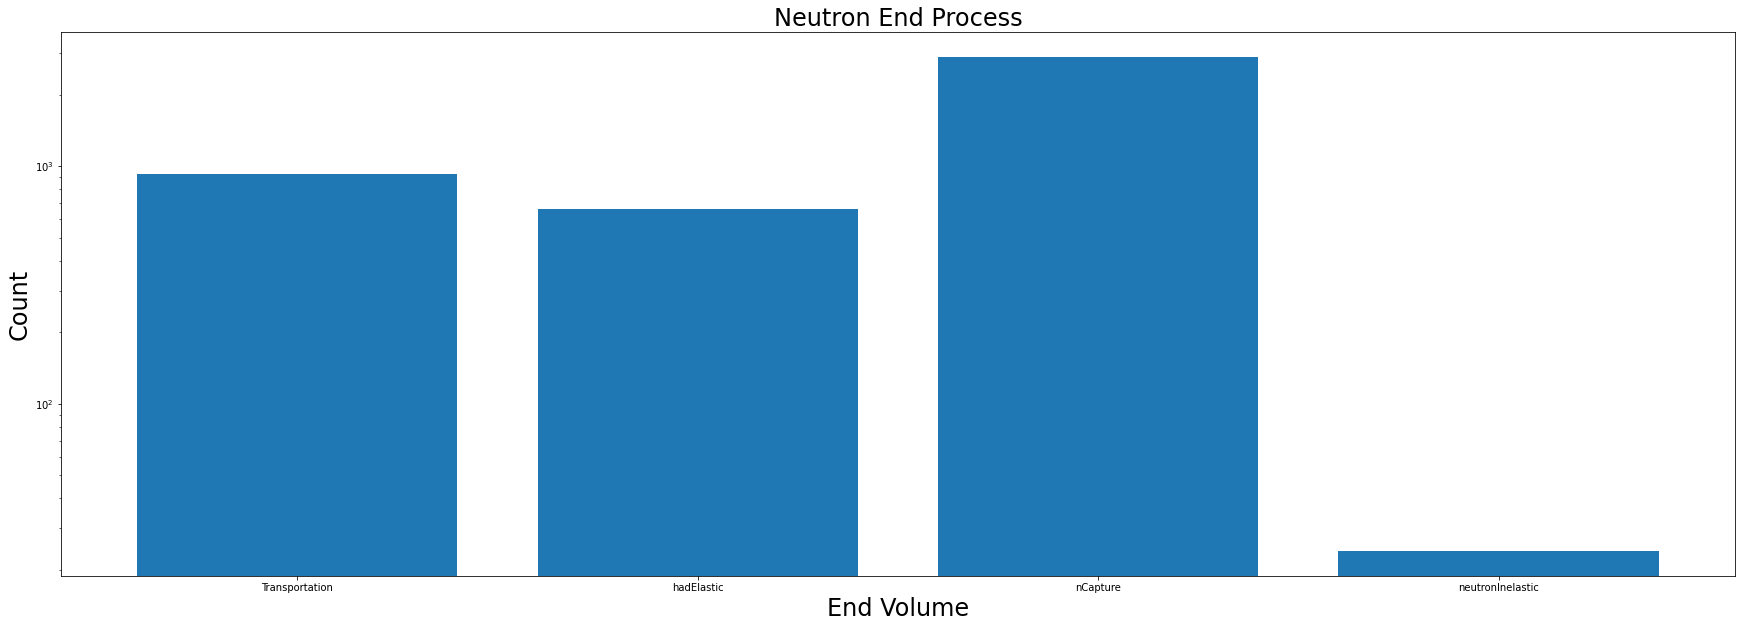

In [57]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
ax.set_ylabel('Count', size = 24 )
ax.set_xlabel('End Volume', size = 24 )
ax.set_title('Neutron End Process', size = 24 ) 
ax.bar(procs, end_process_weights)
ax.set_yscale('log')
plt.show()

### GdLS neutrons

In [58]:
gdls_neutrons = [neutron for neutron in neutron_dictionaries if 'ScintillatorCenter' in neutron['NextVolume']]
died_in_gdls = [neutron for neutron in gdls_neutrons if 'ScintillatorCenter' == neutron['NextVolume'][-1]]
gdls_neutrons_captured = [1 if neutron['ProcName'][-1] == 'nCapture' else 0 for neutron in gdls_neutrons]
died_in_gdls_neutrons_captured = [1 if neutron['ProcName'][-1] == 'nCapture' else 0 for neutron in died_in_gdls]

In [59]:
data = []
data.append(['Enters GdLS', 
             len(gdls_neutrons), len(gdls_neutrons)/len(neutron_dictionaries) *100, len(gdls_neutrons)/len(non_ofw) *100., 
             sum(gdls_neutrons_captured), sum(gdls_neutrons_captured)/len(gdls_neutrons_captured) * 100.,  sum(gdls_neutrons_captured)/len(non_ofw) *100.])
data.append(['Dies in GdLS', 
             len(died_in_gdls), len(died_in_gdls)/len(neutron_dictionaries) *100, len(died_in_gdls)/len(non_ofw) *100.,
             sum(died_in_gdls_neutrons_captured), sum(died_in_gdls_neutrons_captured)/len(died_in_gdls_neutrons_captured) * 100.,  sum(died_in_gdls_neutrons_captured)/len(non_ofw) *100.])
data.append(['Comparison of above', len(died_in_gdls), len(died_in_gdls)/len(gdls_neutrons) *100, len(died_in_gdls)/len(gdls_neutrons) *100,
             sum(died_in_gdls_neutrons_captured) / sum(gdls_neutrons_captured) * 100, sum(died_in_gdls_neutrons_captured) / sum(gdls_neutrons_captured) * 100, sum(died_in_gdls_neutrons_captured) / sum(gdls_neutrons_captured) * 100])

print(tabulate.tabulate(data, headers=['','Number', 'Percent', 'Percent exclude OutOfWorld', 'Get captured', 'Get Captured %', '% OofW']))

                       Number    Percent    Percent exclude OutOfWorld    Get captured    Get Captured %    % OofW
-------------------  --------  ---------  ----------------------------  --------------  ----------------  --------
Enters GdLS              1104    24.5333                       30.8811        443                40.1268  12.3916
Dies in GdLS              975    21.6667                       27.2727        315                32.3077   8.81119
Comparison of above       975    88.3152                       88.3152         71.1061           71.1061  71.1061


In [60]:
end_process = [neutron['ProcName'][-1] for neutron in died_in_gdls]
unique_processes = np.unique(end_process)
end_process_weights = []
procs = []
for uni in unique_processes:
    count = 0
    for j in end_process:
        if j == uni:
            count += 1
    end_process_weights.append(count)
    procs.append(uni)

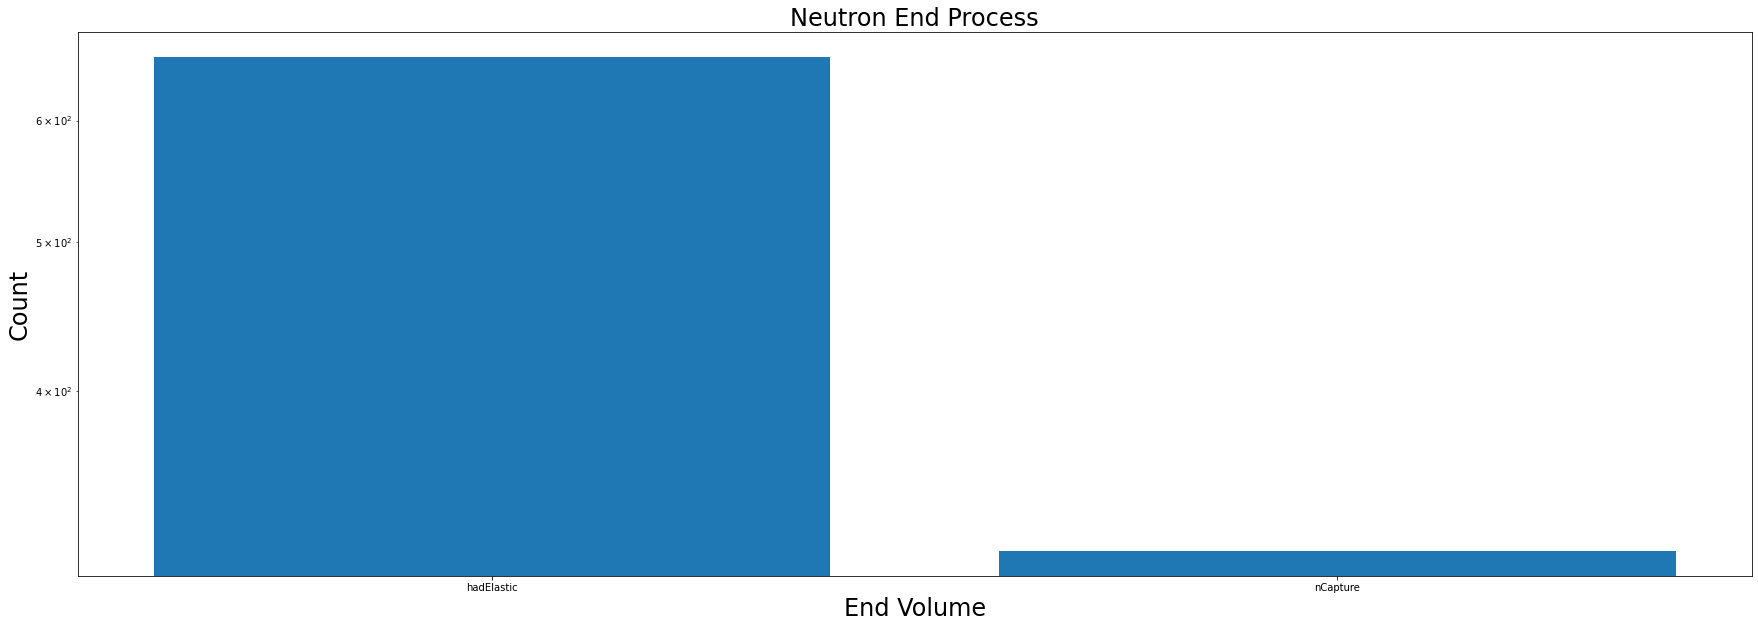

In [61]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
ax.set_ylabel('Count', size = 24 )
ax.set_xlabel('End Volume', size = 24 )
ax.set_title('Neutron End Process', size = 24 ) 
ax.bar(procs, end_process_weights)
ax.set_yscale('log')
plt.show()

In [80]:
def get_seconda(primary_particle_dictionary):

    capture_particle = []
    final_event = []
    
    # Can either be a list or a str depending on if merged or not
    primary_track_id = primary_particle_dictionary['track_id']
    primary_xyz = [primary_particle_dictionary['x_mm'][-1], primary_particle_dictionary['y_mm'][-1], primary_particle_dictionary['z_mm'][-1]]
    
    # Load event dictionaries
    event_list = np.load(primary_particle_dictionary['filename'], allow_pickle=True)


    # Get list[str] of secondaries
    if type(primary_track_id) == list:
        track_id = primary_track_id[-1]
    else:
        track_id = primary_track_id
        
    for particle_dictionary in event_list:
        # Get final 
        if particle_dictionary['track_id'] == track_id:
            try:
                final_event.append(particle_dictionary['ProcName'][-1])
            except:
                #print(particle_dictionary)
                break
        if particle_dictionary['parent_id'] == track_id:
            # check x-y-z
            if type(particle_dictionary['x_mm']) == list:
                if len(particle_dictionary['x_mm']) > 0:
                    particle_xyz = [particle_dictionary['x_mm'][0], particle_dictionary['y_mm'][0], particle_dictionary['z_mm'][0]]
                    if particle_xyz == primary_xyz:
                        # Ignore gamma and electrons and carbon
                        particle = particle_dictionary['particle']
                        if particle != 'gamma' and particle != 'e-' and particle != 'C13' and particle != 'C14' and particle != 'proton' and particle != 'C12':
                            capture_particle.append(particle_dictionary['particle'])
                
        
    return final_event, capture_particle


In [89]:
for neutron in died_in_gdls:
    if len(neutron['x_mm']) == 0:
        print(neutron)
    #print(died_in_gdls[i]['track_id'])
    #print(died_in_gdls[i]['ProcName'][-1])

In [81]:
end_proc = []
captured_particle = []
i = 0
import time
start_time = time.time()
n_files = len(died_in_gdls)
gdls_physics.progress_bars.progress_update(0, n_files, start_time)
for neutron in died_in_gdls:
    a, b = get_seconda(neutron)
    end_proc.append(a)
    captured_particle.append(b)
    i += 1
    gdls_physics.progress_bars.progress_update(i, n_files, start_time)

end_proc_flat = [b for sub_b in end_proc for b in sub_b]
captured_particle_flat = [b for sub_b in captured_particle for b in sub_b]

Number to process = 975 
Progress: [####################] 100.0% 
Average time 1.0s 
Time: 00:15:36 
Remaining time 00:00:00


In [82]:
capture_particle_flat = [b for sub_b in captured_particle for b in sub_b]
unique_captures = np.unique(capture_particle_flat)
capture_weights = []
uni_catpure = []
for uni in unique_captures:
    count = 0
    for j in capture_particle_flat:
        if j == uni:
            count += 1
    capture_weights.append(count)
    uni_catpure.append(uni)

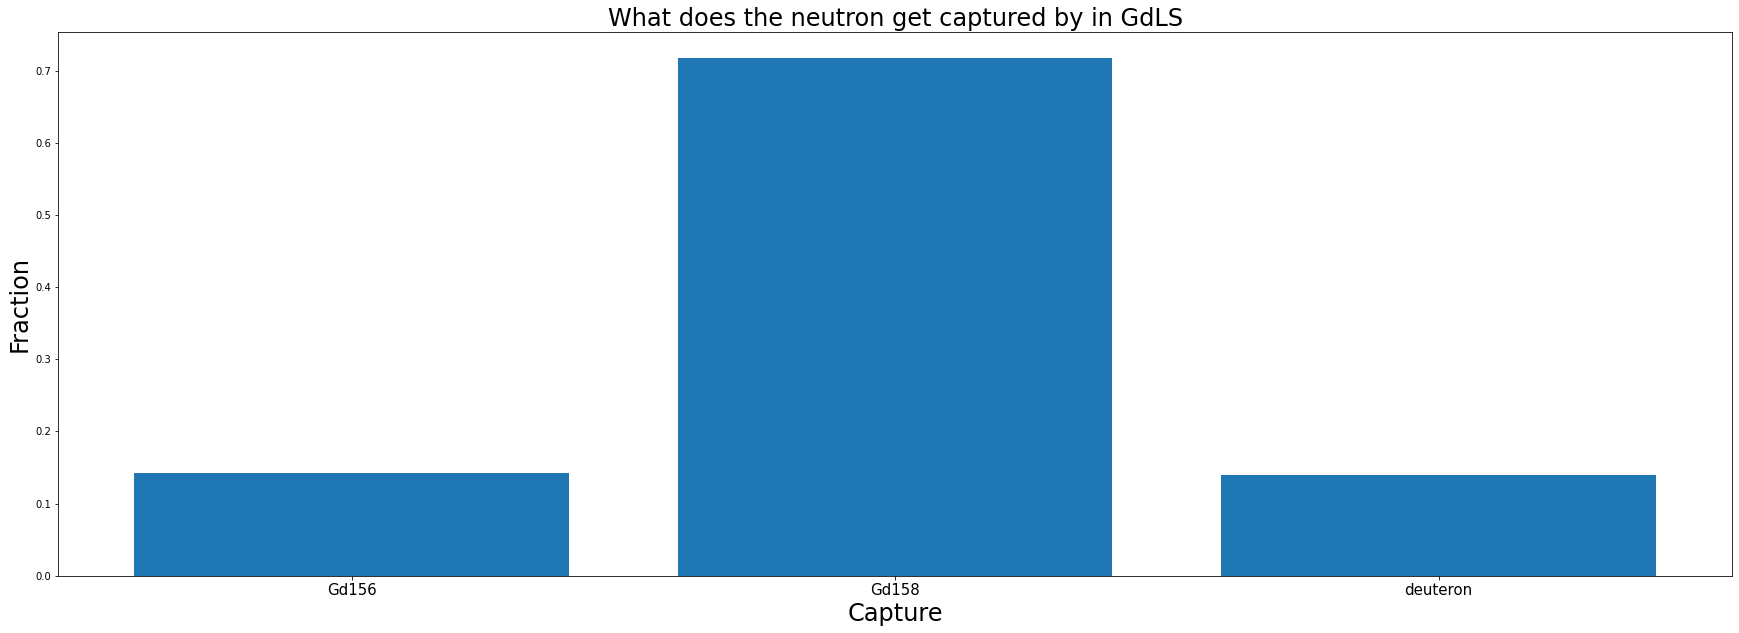

In [83]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
ax.set_ylabel('Fraction', size = 24 )
ax.set_xlabel('Capture', size = 24 )
ax.set_title('What does the neutron get captured by in GdLS', size = 24 ) 
ax.bar(uni_catpure, np.array(capture_weights)/(sum(capture_weights)))
ax.tick_params(axis='x', labelsize=15)
plt.show()

In [84]:
sum(capture_weights)

315

In [85]:
len(died_in_gdls)

975

In [93]:
def get_seconda(primary_particle_dictionary, i):

    capture_particle = []
    ids_not_added = []
    
    # Can either be a list or a str depending on if merged or not
    primary_track_id = primary_particle_dictionary['track_id']
    primary_xyz = [primary_particle_dictionary['x_mm'][-1], primary_particle_dictionary['y_mm'][-1], primary_particle_dictionary['z_mm'][-1]]
    
    # Load event dictionaries
    event_list = np.load(primary_particle_dictionary['filename'], allow_pickle=True)


    # Get list[str] of secondaries
    if type(primary_track_id) == list:
        track_id = primary_track_id[-1]
    else:
        track_id = primary_track_id
        
    for particle_dictionary in event_list:
        # ignore certain particles
        particle = particle_dictionary['particle']
        if particle != 'gamma' and particle != 'e-' and particle != 'C13' and particle != 'C14' and particle != 'proton' and particle != 'C12' and particle != 'opticalphoton':
            if particle_dictionary['parent_id'] == track_id:
                # check x-y-z
                particle_xyz = [particle_dictionary['x_mm'][0], particle_dictionary['y_mm'][0], particle_dictionary['z_mm'][0]]
                if particle_xyz == primary_xyz:
                    capture_particle.append(particle_dictionary['particle'])
                else:
                    ids_not_added.append(i)
        
    return ids_not_added, capture_particle


In [94]:
end_proc = []
ids_not_added = []
i = 0
import time
start_time = time.time()
n_files = len(died_in_gdls)
gdls_physics.progress_bars.progress_update(0, n_files, start_time)
for neutron in died_in_gdls:
    a, b = get_seconda(neutron, i)
    ids_not_added.append(a)
    captured_particle.append(b)
    i += 1
    gdls_physics.progress_bars.progress_update(i, n_files, start_time)

#end_proc_flat = [b for sub_b in end_proc for b in sub_b]
captured_particle_flat = [b for sub_b in captured_particle for b in sub_b]

Number to process = 975 
Progress: [####################] 100.0% 
Average time 1.0s 
Time: 00:15:39 
Remaining time 00:00:00


In [95]:
capture_particle_flat = [b for sub_b in captured_particle for b in sub_b]
unique_captures = np.unique(capture_particle_flat)
capture_weights = []
uni_catpure = []
for uni in unique_captures:
    count = 0
    for j in capture_particle_flat:
        if j == uni:
            count += 1
    capture_weights.append(count)
    uni_catpure.append(uni)

In [96]:
sum(capture_weights)

630

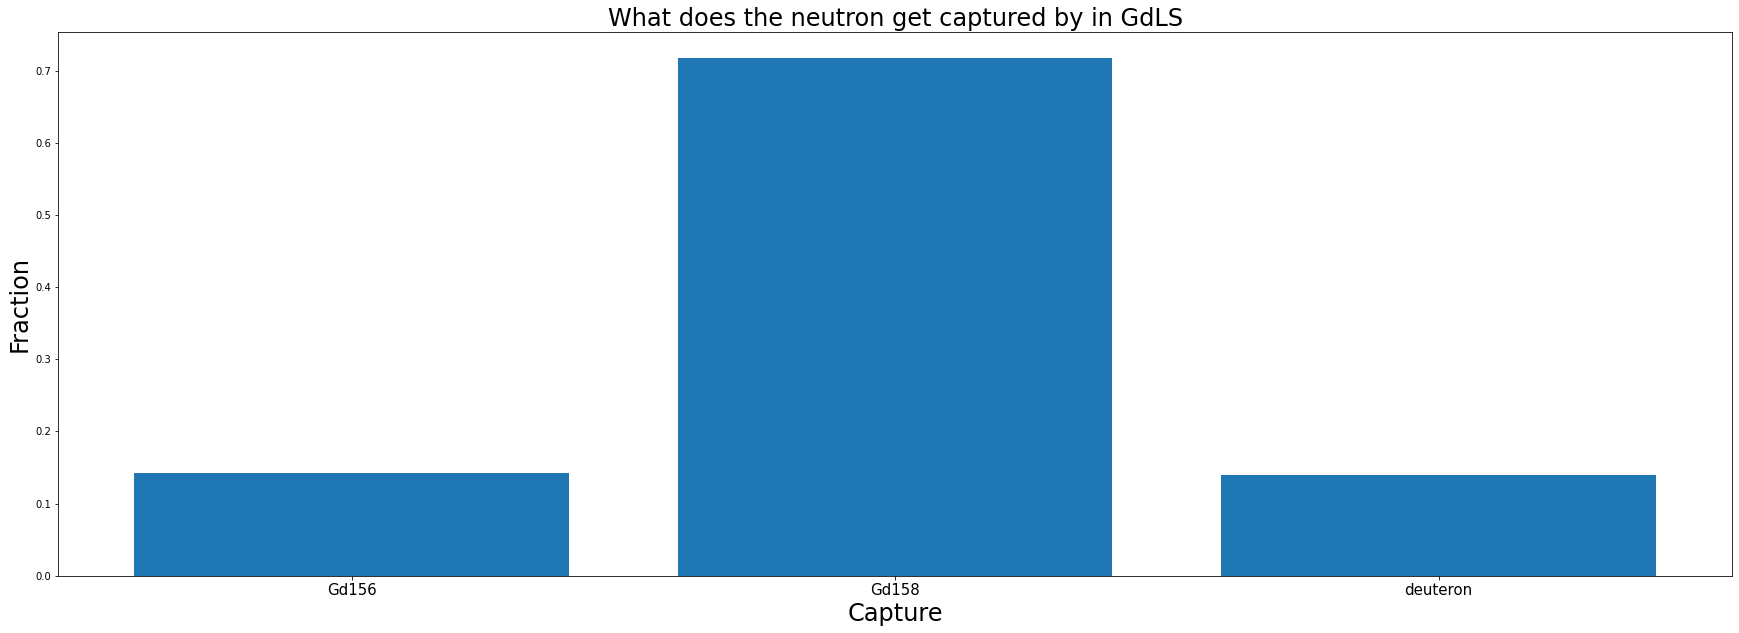

In [97]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
ax.set_ylabel('Fraction', size = 24 )
ax.set_xlabel('Capture', size = 24 )
ax.set_title('What does the neutron get captured by in GdLS', size = 24 ) 
ax.bar(uni_catpure, np.array(capture_weights)/(sum(capture_weights)))
ax.tick_params(axis='x', labelsize=15)
plt.show()